In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [10]:
#explore the tables in the database
inspector = inspect(engine)
m_columns = inspector.get_columns('measurement')
for each_column in m_columns:
    print(f'{each_column["name"]} - {each_column["type"]}')

# measurement id(int), station(text), date(text), prcp(float), tobs(float)
# station id(int), station(text), latitude(float), longiture(float), elevation(float)

id - INTEGER
station - TEXT
date - TEXT
prcp - FLOAT
tobs - FLOAT


In [11]:
s_columns = inspector.get_columns('station')
for each_column in s_columns:
    print(f'{each_column["name"]} - {each_column["type"]}')

id - INTEGER
station - TEXT
name - TEXT
latitude - FLOAT
longitude - FLOAT
elevation - FLOAT


In [12]:
station_display = engine.execute('select * from station')
# station_index = []
# station_id = []
# station_name = []
# station
for each_station in station_display:    
    print(each_station)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)
(6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)


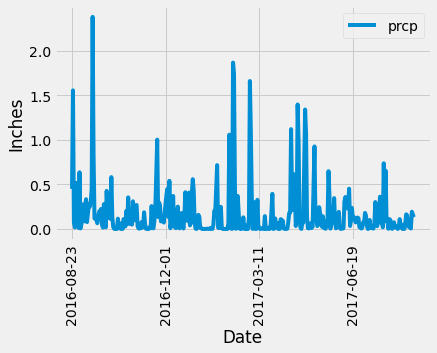

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

last_measure_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year_ago = dt.date(2017,8,23) - dt.timedelta(days=366)
# print(year_ago)

# Perform a query to retrieve the data and precipitation scores
last_twelve_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).all()
# last_twelve_query

# Save the query results as a Pandas DataFrame and set the index to the date column
#dates = [each_date[0] for each_date in last_twelve_query]
# precip = [each_precip[1] for each_precip in last_twelve_query]
last_twelve_df = pd.DataFrame(last_twelve_query)
last_twelve_df = last_twelve_df.set_index('date')
# last_twelve_df

# Sort the dataframe by date
grouped_last_twelve = last_twelve_df.groupby(['date']).mean()
# x_ticks = []
# date_index = 0
# for tickdate in range(10):
#     x_ticks.append(grouped_last_twelve.index[date_index])
#     date_index = date_index + 36
ax = grouped_last_twelve.plot(xlabel='Date',ylabel='Inches',rot='vertical')#, use_index=False)
# ax.set_xticklabels(x_ticks)


In [14]:
grouped_last_twelve

,prcp
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
grouped_last_twelve.describe()

,prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).all()
print(f'There are {station_count[0][0]} stations in this dataset')

There are 9 stations in this dataset


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
                    .order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
most_active = active_stations[0][0]
print(f'The most active station is {most_active}')

The most active station is USC00519281


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_min_temp = session.query(func.min(Measurement.tobs)).all()
most_active_max_temp = session.query(func.max(Measurement.tobs)).all()
most_active_avg_temp = session.query(func.avg(Measurement.tobs)).all()
print(f'For Station {most_active}, the MINIMUM temperature recorded was: {most_active_min_temp[0][0]}')
print(f'For Station {most_active}, the MAXIMUM temperature recorded was: {most_active_max_temp[0][0]}')
print(f'For Station {most_active}, the AVERAGE temperature recorded was: {most_active_avg_temp[0][0]}')

For Station USC00519281, the MINIMUM temperature recorded was: 53.0
For Station USC00519281, the MAXIMUM temperature recorded was: 87.0
For Station USC00519281, the AVERAGE temperature recorded was: 73.09795396419437


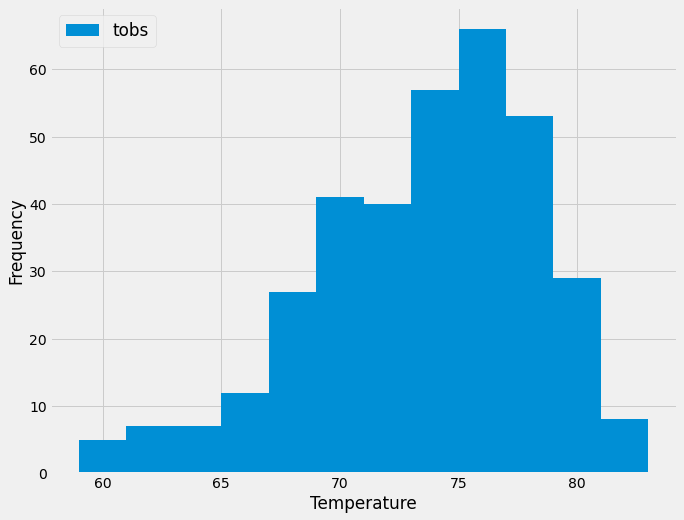

In [22]:
# Choose the station with the highest number of temperature observations.
most_tobs = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station)\
            .order_by(func.count(Measurement.tobs).desc()).all()[0][0]
# most_tobs
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_tobs_last_year = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > year_ago)\
                    .filter(Measurement.station == most_tobs).all()
tobs_dates = [each_day[0] for each_day in most_tobs_last_year]
tobs_temps = [each_day[1] for each_day in most_tobs_last_year]
plt.figure(figsize=(10,8))
plt.hist(tobs_temps, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'],loc=2,fontsize='large')


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
